In [79]:
import cv2
import numpy as np
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
from glob import iglob

from scipy.spatial.distance import cityblock, euclidean, mahalanobis, cosine

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [2]:
rng = np.random.RandomState(23)

In [3]:
# Center features by removing the mean
def center(X):
    return X - np.mean(X, axis=0)

# Standardize features by scaling to unit variance
def standardize(X):
    return X / np.std(X, axis=0)

# Decorrelate components of X
def whiten(X):
    X = center(X)
    eigval, eigvec, = np.linalg.eig(np.cov(X.T))
    K = eigvec @ np.diag(1 / np.sqrt(eigval+1e-9)) @ eigvec.T
    return X @ K.T, K

In [4]:
# Order the eigenvectors according to the magnitude of the eigenvalues
def order_eigenpairs(eigval, eigvec):
    eigpairs = [(eigval[i], eigvec[:,i]) for i in range(len(eigval))]
    eigpairs.sort(reverse=True)
    eigval = np.array([elem.real for elem,_ in eigpairs])
    eigvec = np.array([elem.real for _,elem in eigpairs])
    return eigval, eigvec

# Compute eigenvectors and eigenvalues in descending order of eigenvalue
def ordered_eig(X):
    eigval, eigvec, = np.linalg.eig(X)
    return order_eigenpairs(eigval, eigvec)

# Print cumulative variance of the first n eigenvalues
def cum_var(eigval, n_eigvals):
    print("The cumulative variance of the first " + str(n_eigvals) + " principal components is: " + str(np.sum(eigval[:n_eigvals]) / np.sum(eigval) * 100))

# Perform Principal Component Analysis
def PCA(X, n_components, print_var): # data(n_samples, n_features)
    # Compute eigenvalues and eigenvectors of covariance matrix
    eigval, eigvec = ordered_eig(np.cov(X.T))
    if print_var:
        cum_var(eigval, n_components)
    # Compute the Principal Component space
    PC = eigvec[:n_components]
    return PC

In [5]:
# Kurtosis funtion
def g(u):
    return 4 * u**3

# Derivated kurtosis function
def dg(u):
    return 12 * u**2

# Compute one Independent Component
def compute_unit(X, W):
    w = np.random.rand(X.shape[0])
    w /= np.linalg.norm(w)
    for iter in range(5000):
        w0 = w
        w = (1 / X.shape[1]-1) * X @ g(w.T @ X).T - (1 / X.shape[1]-1) * dg(w.T @ X) @ np.ones((X.shape[1], 1)) * w
        for w_ in W:
            w = w - w.T @ w_ * w_
        w /= np.linalg.norm(w) 
        # Check for convergence
        if (1 - np.abs(w0.T @ w) < 1e-10):
            break
    return w

# Perform Independent Component Analysis
def ICA(X, n_components):
    X, K = whiten(X)
    X = X.T
    W = []
    for i in range(n_components):
        w = compute_unit(X, W)
        W.append(w)
    W = np.vstack(W)
    return W @ K

In [6]:
# Compute the class means and sizes
def class_means(X, y):
    c_means = dict((class_, np.zeros(X.shape[1])) for class_ in set(y))
    c_sizes = dict((class_, 0) for class_ in set(y))
    for index in range(len(y)):
        c_sizes[y[index]] += 1
        c_means[y[index]] += X[index]
    return {i: c_means[i]/c_sizes[i] for i in c_means}, c_sizes

# Compute the between-class matrix
def between_class(c_means, c_sizes, t_mean):
    S_b = np.zeros((len(t_mean), len(t_mean)))
    for class_ in c_means.keys():
        S_b += c_sizes[class_] * np.outer((c_means[class_] - t_mean), (c_means[class_] - t_mean))
    return S_b

# Compute the within-class matrix
def within_class(X, y, c_means):
    X = np.array([X[i] - c_means[y[i]] for i in range(X.shape[0])])
    S_w = np.zeros((X.shape[1], X.shape[1]))
    for class_ in c_means.keys():
        S_w += X[[i for i in range(len(y)) if y[i] == class_]].T @ X[[i for i in range(len(y)) if y[i] == class_]]
    return S_w
    
# Perform Linear Discriminant Analysis
def LDA(X, y, n_dimensions):
    c_means, c_sizes = class_means(X, y)
    t_mean = np.array(list(c_means.values())).mean(axis=0)
    S_b = between_class(c_means, c_sizes, t_mean)
    S_w = within_class(X, y, c_means)
    W = np.linalg.inv(S_w) @ S_b
    eigval, eigvec = ordered_eig(np.cov(W))
    return eigvec[:n_dimensions]

In [171]:
# Display scatterplot of the data
def plot_data(X, title):
    if X.shape[1] == 1:
        plt.scatter(X[:, 0], np.zeros(X.shape[0]), s=5, color='steelblue', alpha=0.5)
    else:
        plt.scatter(X[:, 0], X[:, 1], s=5, color='steelblue', alpha=0.5)
    plt.hlines(0, -3, 3, linestyle=':'); plt.vlines(0, -3, 3, linestyle=':')
    plt.xlim(-3, 3); plt.ylim(-3, 3)
    plt.title(title)
    
# Display a list of vectors on a plot
def plot_vectors(vectors):
    for vector in vectors:
        x_axis, y_axis = vector
        plt.plot(0.1 * x_axis, 0.1 * y_axis, linewidth=2)
        plt.quiver(0, 0, x_axis, y_axis, zorder=11, width=0.01, scale=6)

# Display the results of experiments
def create_report(X, transform, title1, title2, title3):
    plt.figure(figsize=(17, 5))
    plt.subplot(131); plot_data(X / X.std(), title1)
    plt.subplot(132); plot_data(X / X.std(), title2); plot_vectors(transform.T) if transform.shape[0] == 2 else plot_vectors(transform)
    plt.subplot(133); plot_data(standardize(X @ transform.T), title3)
    plt.show()

# Conduct a test to check the accuracy of PCA on a dummy dataset
def test_PCA():
    A = np.array([[1, 0], [2, 2]])
    X = rng.normal(0, 1, size=(5000, 2))
    X_pca = X @ A
    X_pca = center(X_pca); X_pca = standardize(X_pca)
    pca = PCA(X_pca, 2, False)
    # Display results
    create_report(X_pca, pca, "Initial Data", "Principal Components", "PCA Recovered Signals")
    
# Conduct a test to check the accuracy of ICA on a dummy dataset
def test_ICA():
    A = np.array([[1, 0], [1, 2]])
    X = rng.standard_t(1.5, size=(15000, 2))
    X_ica = X @ A
    X_ica = center(X_ica); X_ica = standardize(X_ica)
    ica = ICA(X_ica, 2)
    # Display results
    create_report(X_ica, ica, "Initial Data", "Independent Components", "ICA Recovered Signals")
        
# Conduct a test to check the accuracy of LDA on a dummy dataset
def test_LDA():
    A = np.array([[-1, -2], [2, 1]])
    X = np.concatenate((rng.normal(-7, 2, size=(5000, 2)), rng.normal(7, 2, size=(5000, 2))), axis=0)
    X_lda = X @ A
    y_lda = [0] * 5000 + [1] * 5000
    X_lda = center(X_lda); X_lda = standardize(X_lda)
    lda = LDA(X_lda, y_lda, 1)
    # Display results
    create_report(X_lda, lda, "Initial Data", "Separating Hyperplane", "ICA Recovered Signals")

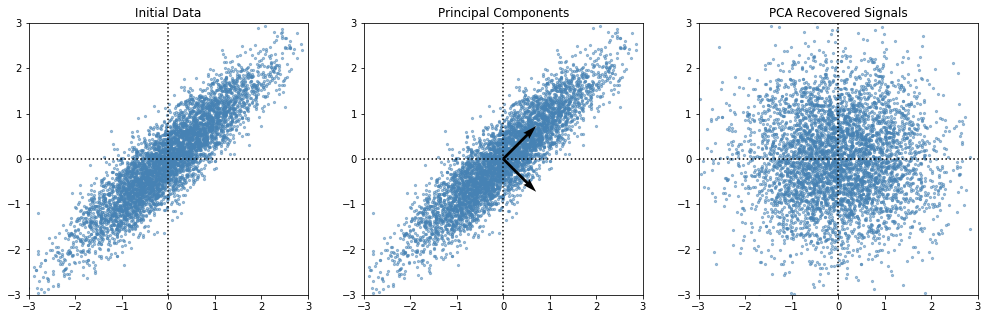

In [173]:
test_PCA()

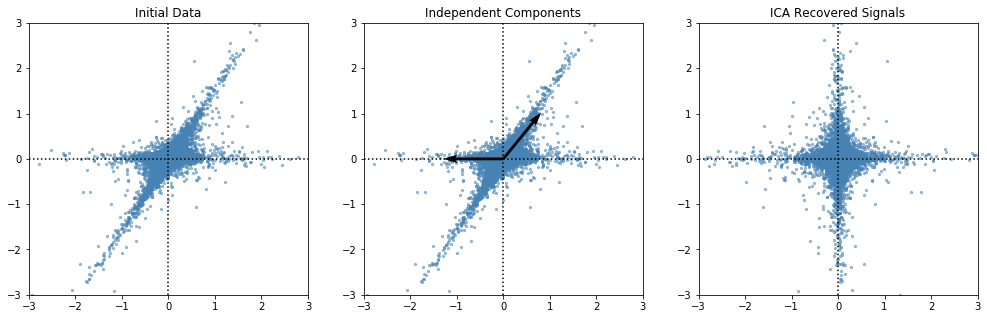

In [121]:
test_ICA()

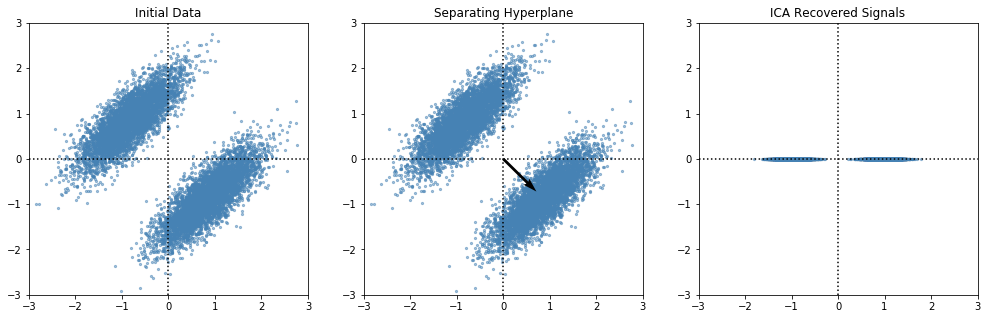

In [172]:
test_LDA()

In [7]:
# Read image files
def read_images(directory_name):
    X = []; y = []
    for image in iglob("feret_dataset/" + directory_name + "/*.pgm"):
        face = cv2.resize(plt.imread(image), (50, 60)).flatten()
        X = np.append(X, face)
        y = np.append(y, image.split("/")[2][:5])
    X = np.reshape(X, (-1, 3000))
    return X, y

In [29]:
X, y = read_images("training_set")
X = center(X); X = standardize(X)

pca = PCA(X, 270, True)
pca_ = PCA(X.T, 270, True)

ica1 = ICA(X.T @ pca_.T, 270)
ica2 = ICA(X @ pca.T, 270)
lda = LDA(X @ pca.T, y, 224)

The cumulative variance of the first 270 principal components is: 98.55830156287358
The cumulative variance of the first 270 principal components is: 96.99928229945857


In [30]:
ica1 = ica1 @ pca#_
ica2 = ica2 @ pca
lda = lda @ pca

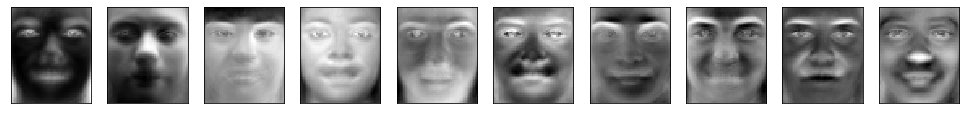

In [21]:
fig, axes = plt.subplots(1, 10, figsize=(17, 3), subplot_kw={"xticks":[], "yticks":[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(pca[i].reshape(60, 50), cmap="gray")

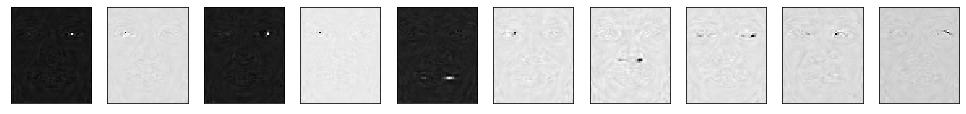

In [22]:
ica1_ = ica1 @ X
fig, axes = plt.subplots(1, 10, figsize=(17, 3), subplot_kw={"xticks":[], "yticks":[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(ica1_[i].reshape(60, 50), cmap="gray")

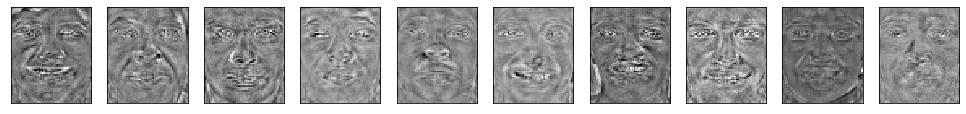

In [23]:
fig, axes = plt.subplots(1, 10, figsize=(17, 3), subplot_kw={"xticks":[], "yticks":[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(ica2[i].reshape(60, 50), cmap="gray")

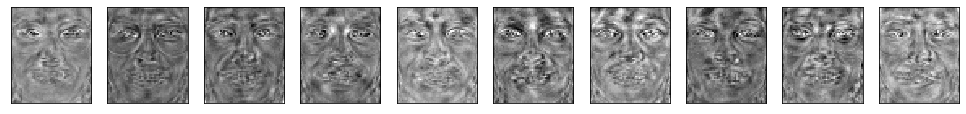

In [24]:
fig, axes = plt.subplots(1, 10, figsize=(17, 3), subplot_kw={"xticks":[], "yticks":[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(lda[i].reshape(60, 50), cmap="gray")

In [27]:
Xg, yg = read_images("gallery")
Xg = center(Xg); Xg = standardize(Xg)
Xg_pca = Xg @ pca.T
Xg_ica1 = Xg @ ica1.T
Xg_ica2 = Xg @ ica2.T
Xg_lda = Xg @ lda.T

In [33]:
Xfb, yfb = read_images("fb")
Xfb = center(Xfb); Xfb = standardize(Xfb)
Xfb_pca = Xfb @ pca.T
Xfb_ica1 = Xfb @ ica1.T
Xfb_ica2 = Xfb @ ica2.T
Xfb_lda = Xfb @ lda.T

In [34]:
Xfc, yfc = read_images("fc")
Xfc = center(Xfc); Xfc = standardize(Xfc)
Xfc_pca = Xfc @ pca.T
Xfc_ica1 = Xfc @ ica1.T
Xfc_ica2 = Xfc @ ica2.T
Xfc_lda = Xfc @ lda.T

In [35]:
Xd1, yd1 = read_images("dup1")
Xd1 = center(Xd1); Xd1 = standardize(Xd1)
Xd1_pca = Xd1 @ pca.T
Xd1_ica1 = Xd1 @ ica1.T
Xd1_ica2 = Xd1 @ ica2.T
Xd1_lda = Xd1 @ lda.T

In [36]:
Xd2, yd2 = read_images("dup2")
Xd2 = center(Xd2); Xd2 = standardize(Xd2)
Xd2_pca = Xd2 @ pca.T
Xd2_ica1 = Xd2 @ ica1.T
Xd2_ica2 = Xd2 @ ica2.T
Xd2_lda = Xd2 @ lda.T

In [103]:
def kNN(k, metric, xp, Xg, yg):
    order = []
    for i in range(len(Xg)):
        if metric == "L1":
            order.append((cityblock(xp, Xg[i]), i))
        if metric == "L2":
            order.append((euclidean(xp, Xg[i]), i))
        if metric == "MAH":
            cov = np.cov(xp, Xg[i])
            cov_ = np.linalg.inv(cov)
            print(cov_.shape)
            order.append((mahalanobis(xp, Xg[i], cov_), i))
        if metric == "COS":
            order.append((cosine(xp, Xg[i]), i))
    order = sorted(order)
    return [yg[i[1]] for i in order[:k]]

def perf(rank, metric, Xp, yp, Xg, yg):
    true = 0
    total = len(Xp)
    for i in range(total):
        if yp[i] in kNN(rank, metric, Xp[i], Xg, yg):
            true += 1
    return round(true / total * 100, 2)

In [104]:
print("PCA+L1: " + str(perf(1, "L1", Xfb_pca, yfb, Xg_pca, yg)) + "%")
print("PCA+L2: " + str(perf(1, "L2", Xfb_pca, yfb, Xg_pca, yg)) + "%")
#print("PCA+MAH: " + str(perf(1, "MAH", Xfb_pca, yfb, Xg_pca, yg)) + "%")
print("PCA+COS: " + str(perf(1, "COS", Xfb_pca, yfb, Xg_pca, yg)) + "%")

PCA+L1: 74.23%
PCA+L2: 66.03%
PCA+COS: 68.95%


In [37]:
# Fit PCA Nearest Neighbor classifiers
l1_pca = NearestNeighbors(n_neighbors=1, metric="l1").fit(Xg_pca)
l2_pca = NearestNeighbors(n_neighbors=1, metric="l2").fit(Xg_pca)
mah_pca = NearestNeighbors(n_neighbors=1, metric="mahalanobis", metric_params={'V': np.cov(Xg_pca.T)}).fit(Xg_pca)
cos_pca = NearestNeighbors(n_neighbors=1, metric="cosine").fit(Xg_pca)
# Fit ICA1 Nearest Neighbor classifiers
l1_ica1 = NearestNeighbors(n_neighbors=1, metric="l1").fit(Xg_ica1)
l2_ica1 = NearestNeighbors(n_neighbors=1, metric="l2").fit(Xg_ica1)
mah_ica1 = NearestNeighbors(n_neighbors=1, metric="mahalanobis", metric_params={'V': np.cov(Xg_ica1.T)}).fit(Xg_ica1)
cos_ica1 = NearestNeighbors(n_neighbors=1, metric="cosine").fit(Xg_ica1)
# Fit ICA2 Nearest Neighbor classifiers
l1_ica2 = NearestNeighbors(n_neighbors=1, metric="l1").fit(Xg_ica2)
l2_ica2 = NearestNeighbors(n_neighbors=1, metric="l2").fit(Xg_ica2)
mah_ica2 = NearestNeighbors(n_neighbors=1, metric="mahalanobis", metric_params={'V': np.cov(Xg_ica2.T)}).fit(Xg_ica2)
cos_ica2 = NearestNeighbors(n_neighbors=1, metric="cosine").fit(Xg_ica2)
# Fit LDA Nearest Neighbor classifiers
l1_lda = NearestNeighbors(n_neighbors=1, metric="l1").fit(Xg_lda)
l2_lda = NearestNeighbors(n_neighbors=1, metric="l2").fit(Xg_lda)
mah_lda = NearestNeighbors(n_neighbors=1, metric="mahalanobis", metric_params={'V': np.cov(Xg_lda.T)}).fit(Xg_lda)
cos_lda = NearestNeighbors(n_neighbors=1, metric="cosine").fit(Xg_lda)

In [39]:
# Calculate the performance of an algorithms wrt a measure
def performance(nn, X_pr, y_pr, X_gal, y_gal, rank):
    true = 0
    total = X_pr.shape[0]
    for i in range(total):
        if y_pr[i] in [y_gal[i] for i in nn.kneighbors(X=[X_pr[i]], n_neighbors=rank)[1][0]]:
            true += 1
    return round(true / total * 100, 2)

# Create a CSM plot
def CSM(nn, probe, gallery):
    csm = []
    for rank in range(0, 81, 5):
        if rank == 0:
            csm.append(performance(nn, probe, gallery, rank+1))
        else:
            csm.append(performance(nn, probe, gallery, rank))
    return csm

In [40]:
print("PCA+L1: " + str(performance(l1_pca, Xfb_pca, yfb, Xg_pca, yg, 1)) + "%")
print("PCA+L2: " + str(performance(l2_pca, Xfb_pca, yfb, Xg_pca, yg, 1)) + "%")
print("PCA+MAH: " + str(performance(mah_pca, Xfb_pca, yfb, Xg_pca, yg, 1)) + "%")
print("PCA+COS: " + str(performance(cos_pca, Xfb_pca, yfb, Xg_pca, yg, 1)) + "%")

PCA+L1: 74.23%
PCA+L2: 66.03%
PCA+MAH: 51.97%
PCA+COS: 68.95%


In [41]:
print("ICA1+L1: " + str(performance(l1_ica1, Xfb_ica1, yfb, Xg_ica1, yg, 1)) + "%")
print("ICA1+L2: " + str(performance(l2_ica1, Xfb_ica1, yfb, Xg_ica1, yg, 1)) + "%")
print("ICA1+MAH: " + str(performance(mah_ica1, Xfb_ica1, yfb, Xg_ica1, yg, 1)) + "%")
print("ICA1+COS: " + str(performance(cos_ica1, Xfb_ica1, yfb, Xg_ica1, yg, 1)) + "%")

ICA1+L1: 62.51%
ICA1+L2: 62.76%
ICA1+MAH: 51.97%
ICA1+COS: 76.74%


In [186]:
print("ICA2+L1: " + str(performance(l1_ica2, Xfb_ica2, yfb, Xg_ica2, yg, 1)) + "%")
print("ICA2+L2: " + str(performance(l2_ica2, Xfb_ica2, yfb, Xg_ica2, yg, 1)) + "%")
print("ICA2+MAH: " + str(performance(mah_ica2, Xfb_ica2, yfb, Xg_ica2, yg, 1)) + "%")
print("ICA2+COS: " + str(performance(cos_ica2, Xfb_ica2, yfb, Xg_ica2, yg, 1)) + "%")

ICA2+L1: 56.65%
ICA2+L2: 59.83%
ICA2+MAH: 51.97%
ICA2+COS: 76.82%


In [187]:
print("LDA+L1: " + str(performance(l1_lda, X_fb_lda, y_fb, X_gal_lda, y_gal, 1)) + "%")
print("LDA+L2: " + str(performance(l2_lda, X_fb_lda, y_fb, X_gal_lda, y_gal, 1)) + "%")
print("LDA+MAH: " + str(performance(mah_lda, X_fb_lda, y_fb, X_gal_lda, y_gal, 1)) + "%")
print("LDA+COS: " + str(performance(cos_lda, X_fb_lda, y_fb, X_gal_lda, y_gal, 1)) + "%")

LDA+L1: 82.85%
LDA+L2: 80.92%
LDA+MAH: 58.49%
LDA+COS: 85.61%


In [188]:
print("PCA+L1: " + str(performance(l1_pca, X_fc_pca, y_fc, X_gal_pca, y_gal, 1)) + "%")
print("PCA+L2: " + str(performance(l2_pca, X_fc_pca, y_fc, X_gal_pca, y_gal, 1)) + "%")
print("PCA+MAH: " + str(performance(mah_pca, X_fc_pca, y_fc, X_gal_pca, y_gal, 1)) + "%")
print("PCA+COS: " + str(performance(cos_pca, X_fc_pca, y_fc, X_gal_pca, y_gal, 1)) + "%")

PCA+L1: 59.28%
PCA+L2: 28.87%
PCA+MAH: 45.36%
PCA+COS: 37.63%


In [189]:
print("ICA2+L1: " + str(performance(l1_ica2, X_fc_ica2, y_fc, X_gal_ica2, y_gal, 1)) + "%")
print("ICA2+L2: " + str(performance(l2_ica2, X_fc_ica2, y_fc, X_gal_ica2, y_gal, 1)) + "%")
print("ICA2+MAH: " + str(performance(mah_ica2, X_fc_ica2, y_fc, X_gal_ica2, y_gal, 1)) + "%")
print("ICA2+COS: " + str(performance(cos_ica2, X_fc_ica2, y_fc, X_gal_ica2, y_gal, 1)) + "%")

ICA2+L1: 28.87%
ICA2+L2: 43.81%
ICA2+MAH: 45.36%
ICA2+COS: 62.89%


In [190]:
print("LDA+L1: " + str(performance(l1_lda, X_fc_lda, y_fc, X_gal_lda, y_gal, 1)) + "%")
print("LDA+L2: " + str(performance(l2_lda, X_fc_lda, y_fc, X_gal_lda, y_gal, 1)) + "%")
print("LDA+MAH: " + str(performance(mah_lda, X_fc_lda, y_fc, X_gal_lda, y_gal, 1)) + "%")
print("LDA+COS: " + str(performance(cos_lda, X_fc_lda, y_fc, X_gal_lda, y_gal, 1)) + "%")

LDA+L1: 95.88%
LDA+L2: 89.69%
LDA+MAH: 72.16%
LDA+COS: 89.69%


In [191]:
print("PCA+L1: " + str(performance(l1_pca, X_dup1_pca, y_dup1, X_gal_pca, y_gal, 1)) + "%")
print("PCA+L2: " + str(performance(l2_pca, X_dup1_pca, y_dup1, X_gal_pca, y_gal, 1)) + "%")
print("PCA+MAH: " + str(performance(mah_pca, X_dup1_pca, y_dup1, X_gal_pca, y_gal, 1)) + "%")
print("PCA+COS: " + str(performance(cos_pca, X_dup1_pca, y_dup1, X_gal_pca, y_gal, 1)) + "%")

PCA+L1: 32.27%
PCA+L2: 19.53%
PCA+MAH: 21.88%
PCA+COS: 23.96%


In [192]:
print("ICA2+L1: " + str(performance(l1_ica2, X_dup1_ica2, y_dup1, X_gal_ica2, y_gal, 1)) + "%")
print("ICA2+L2: " + str(performance(l2_ica2, X_dup1_ica2, y_dup1, X_gal_ica2, y_gal, 1)) + "%")
print("ICA2+MAH: " + str(performance(mah_ica2, X_dup1_ica2, y_dup1, X_gal_ica2, y_gal, 1)) + "%")
print("ICA2+COS: " + str(performance(cos_ica2, X_dup1_ica2, y_dup1, X_gal_ica2, y_gal, 1)) + "%")

ICA2+L1: 28.39%
ICA2+L2: 28.95%
ICA2+MAH: 21.88%
ICA2+COS: 39.89%


In [193]:
print("LDA+L1: " + str(performance(l1_lda, X_dup1_lda, y_dup1, X_gal_lda, y_gal, 1)) + "%")
print("LDA+L2: " + str(performance(l2_lda, X_dup1_lda, y_dup1, X_gal_lda, y_gal, 1)) + "%")
print("LDA+MAH: " + str(performance(mah_lda, X_dup1_lda, y_dup1, X_gal_lda, y_gal, 1)) + "%")
print("LDA+COS: " + str(performance(cos_lda, X_dup1_lda, y_dup1, X_gal_lda, y_gal, 1)) + "%")

LDA+L1: 40.44%
LDA+L2: 37.67%
LDA+MAH: 24.1%
LDA+COS: 41.83%


In [194]:
print("PCA+L1: " + str(performance(l1_pca, X_dup2_pca, y_dup2, X_gal_pca, y_gal, 1)) + "%")
print("PCA+L2: " + str(performance(l2_pca, X_dup2_pca, y_dup2, X_gal_pca, y_gal, 1)) + "%")
print("PCA+MAH: " + str(performance(mah_pca, X_dup2_pca, y_dup2, X_gal_pca, y_gal, 1)) + "%")
print("PCA+COS: " + str(performance(cos_pca, X_dup2_pca, y_dup2, X_gal_pca, y_gal, 1)) + "%")

PCA+L1: 20.51%
PCA+L2: 10.68%
PCA+MAH: 11.11%
PCA+COS: 14.53%


In [195]:
print("ICA2+L1: " + str(performance(l1_ica2, X_dup2_ica2, y_dup2, X_gal_ica2, y_gal, 1)) + "%")
print("ICA2+L2: " + str(performance(l2_ica2, X_dup2_ica2, y_dup2, X_gal_ica2, y_gal, 1)) + "%")
print("ICA2+MAH: " + str(performance(mah_ica2, X_dup2_ica2, y_dup2, X_gal_ica2, y_gal, 1)) + "%")
print("ICA2+COS: " + str(performance(cos_ica2, X_dup2_ica2, y_dup2, X_gal_ica2, y_gal, 1)) + "%")

ICA2+L1: 16.67%
ICA2+L2: 17.52%
ICA2+MAH: 11.11%
ICA2+COS: 35.9%


In [196]:
print("LDA+L1: " + str(performance(l1_lda, X_dup2_lda, y_dup2, X_gal_lda, y_gal, 1)) + "%")
print("LDA+L2: " + str(performance(l2_lda, X_dup2_lda, y_dup2, X_gal_lda, y_gal, 1)) + "%")
print("LDA+MAH: " + str(performance(mah_lda, X_dup2_lda, y_dup2, X_gal_lda, y_gal, 1)) + "%")
print("LDA+COS: " + str(performance(cos_lda, X_dup2_lda, y_dup2, X_gal_lda, y_gal, 1)) + "%")

LDA+L1: 25.64%
LDA+L2: 25.64%
LDA+MAH: 10.68%
LDA+COS: 34.62%


In [23]:
CMS_fb = pd.DataFrame()

In [25]:
CMS_fb["PCA_L1"] = CSM(nn_l1, fb, gallery)
CMS_fb["PCA_L2"] = CSM(nn_l2, fb, gallery)
CMS_fb["PCA_COS"] = CSM(nn_cos, fb, gallery)
CMS_fb["PCA_MAH"] = CSM(nn_mah, fb, gallery)

In [27]:
CMS_fb = CMS_fb.reset_index().rename(columns={'index':'rank'})
CMS_fb['rank'] *= 5
CMS_fb.at[0, 'rank'] = 1

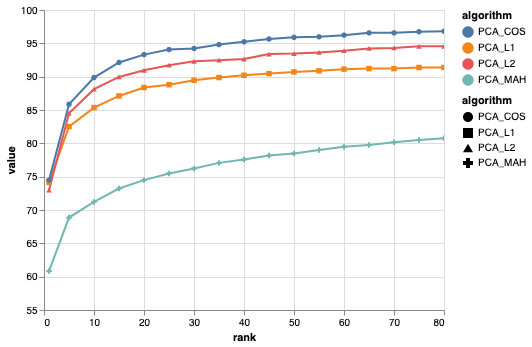

In [29]:
CMS_fb = pd.melt(CMS_fb, id_vars=['rank'], value_vars=['PCA_L1', 'PCA_L2', 'PCA_COS', 'PCA_MAH']).rename(columns={'variable': 'algorithm'})

alt.Chart(CMS_fb).mark_line().encode(
    alt.X('rank:Q'),
    alt.Y('value:Q', scale=alt.Scale(domain=(55, 100))),
    alt.Color('algorithm:N'),
    alt.Shape('algorithm:N'),
    alt.Tooltip('value:Q')
).interactive()

In [30]:
nn_l1 = NearestNeighbors(n_neighbors=1, metric="manhattan")
nn_l1.fit(gallery)
print(str(performance(nn_l1, fc, gallery, 1)) + " %")

65.98 %


In [31]:
nn_l2 = NearestNeighbors(n_neighbors=1, metric="euclidean")
nn_l2.fit(gallery)
print(str(performance(nn_l2, fc, gallery, 1)) + " %")

53.09 %


In [32]:
nn_mah = NearestNeighbors(n_neighbors=1, metric="mahalanobis", metric_params={'V': np.cov(gallery.T)})
nn_mah.fit(gallery)
print(str(performance(nn_mah, fc, gallery, 1)) + " %")

52.58 %


In [33]:
nn_cos = NearestNeighbors(n_neighbors=1, metric="cosine")
nn_cos.fit(gallery)
print(str(performance(nn_cos, fc, gallery, 1)) + " %")

45.88 %


In [42]:
CMS_fc = pd.DataFrame()

In [43]:
CMS_fc["PCA_L1"] = CSM(nn_l1, fc, gallery)
CMS_fc["PCA_L2"] = CSM(nn_l2, fc, gallery)
CMS_fc["PCA_COS"] = CSM(nn_cos, fc, gallery)
CMS_fc["PCA_MAH"] = CSM(nn_mah, fc, gallery)

In [44]:
CMS_fc = CMS_fc.reset_index().rename(columns={'index':'rank'})
CMS_fc['rank'] *= 5
CMS_fc.at[0, 'rank'] = 1

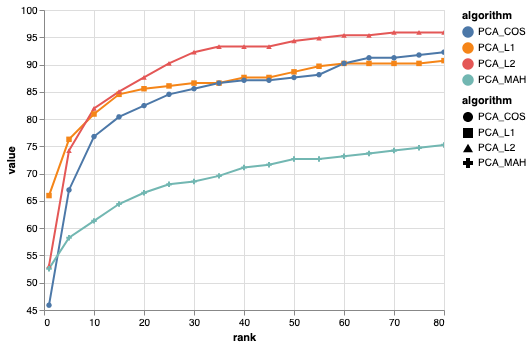

In [46]:
CMS_fc = pd.melt(CMS_fc, id_vars=['rank'], value_vars=['PCA_L1', 'PCA_L2', 'PCA_COS', 'PCA_MAH']).rename(columns={'variable': 'algorithm'})

alt.Chart(CMS_fc).mark_line().encode(
    alt.X('rank:Q'),
    alt.Y('value:Q', scale=alt.Scale(domain=(45, 100))),
    alt.Color('algorithm:N'),
    alt.Shape('algorithm:N'),
    alt.Tooltip('value:Q')
).interactive()

In [53]:
CMS_dup1 = pd.DataFrame()

In [54]:
CMS_dup1["PCA_L1"] = CSM(nn_l1, dup1, gallery)
CMS_dup1["PCA_L2"] = CSM(nn_l2, dup1, gallery)
CMS_dup1["PCA_COS"] = CSM(nn_cos, dup1, gallery)
CMS_dup1["PCA_MAH"] = CSM(nn_mah, dup1, gallery)

In [55]:
CMS_dup1 = CMS_dup1.reset_index().rename(columns={'index':'rank'})
CMS_dup1['rank'] *= 5
CMS_dup1.at[0, 'rank'] = 1

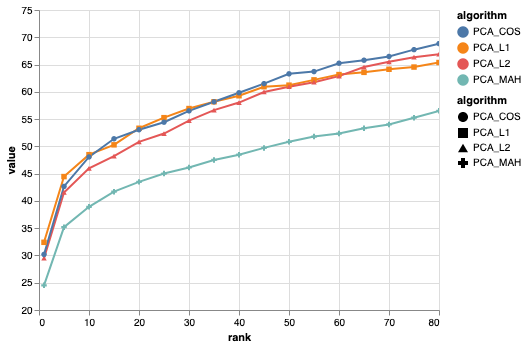

In [58]:
CMS_dup1 = pd.melt(CMS_dup1, id_vars=['rank'], value_vars=['PCA_L1', 'PCA_L2', 'PCA_COS', 'PCA_MAH']).rename(columns={'variable': 'algorithm'})

alt.Chart(CMS_dup1).mark_line().encode(
    alt.X('rank:Q'),
    alt.Y('value:Q', scale=alt.Scale(domain=(20, 75))),
    alt.Color('algorithm:N'),
    alt.Shape('algorithm:N'),
    alt.Tooltip('value:Q')
).interactive()

In [63]:
CMS_dup2 = pd.DataFrame()

In [64]:
CMS_dup2["PCA_L1"] = CSM(nn_l1, dup2, gallery)
CMS_dup2["PCA_L2"] = CSM(nn_l2, dup2, gallery)
CMS_dup2["PCA_COS"] = CSM(nn_cos, dup2, gallery)
CMS_dup2["PCA_MAH"] = CSM(nn_mah, dup2, gallery)

In [65]:
CMS_dup2 = CMS_dup2.reset_index().rename(columns={'index':'rank'})
CMS_dup2['rank'] *= 5
CMS_dup2.at[0, 'rank'] = 1

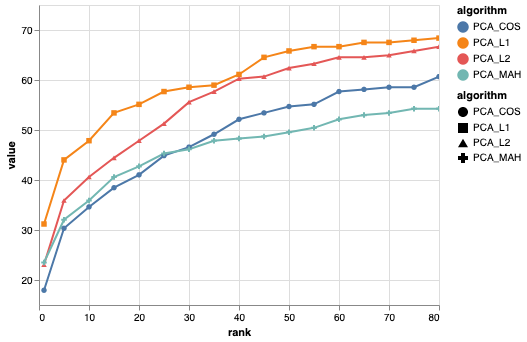

In [66]:
CMS_dup2 = pd.melt(CMS_dup2, id_vars=['rank'], value_vars=['PCA_L1', 'PCA_L2', 'PCA_COS', 'PCA_MAH']).rename(columns={'variable': 'algorithm'})

alt.Chart(CMS_dup2).mark_line().encode(
    alt.X('rank:Q'),
    alt.Y('value:Q', scale=alt.Scale(domain=(15, 75))),
    alt.Color('algorithm:N'),
    alt.Shape('algorithm:N'),
    alt.Tooltip('value:Q')
).interactive()

In [ ]:
# Plot rows of 10 images from a dataset
def plot_images(n_rows, X, title):
    fig, axes = plt.subplots(n_rows, 10, figsize=(17, 2), subplot_kw={"xticks":[], "yticks":[]})
    for i, ax in enumerate(axes.flat):
        ax.imshow(X[i].reshape(60, 50))
    fig.suptitle(title)